I have daily surface and bottom temperature files downloaded for my North Atlantic crop from 1994-2018, and just need to redo 1993 or crop 1993.

I have two tasks. One is to make two bricks (sst and bt) of monthly means to use for backcasting. The other is to either make huge daily bricks for calculating min/max and stdev, or monthly bricks if those are too big. Going with monthly bricks for max/min: I'll take the max or min value for each month. 

In [2]:
# Setup, from Pangeo ESGF search and load notebook
#https://github.com/pangeo-data/pangeo-cmip6-examples/blob/master/search_and_load_with_esgf_opendap.ipynb

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
#from ftplib import FTP
import os, sys, os.path

# https://livebook.manning.com/book/geoprocessing-with-python/chapter-11/103 (has timed access, want 11.8)
#from osgeo import gdal
#import ospybook as pb

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# try to open full dataset, see how big it is
glorys_files = glob.glob('U:/Documents/conda_dir/GLORYS_subsets/GLORYS_REANALYSIS' + '*.nc')
len (glorys_files) # should be 9490

9490

In [4]:
%time glorys_full = xr.open_mfdataset(glorys_files, combine = 'by_coords', chunks = {'time':12}) # 15min
glorys_full

Wall time: 16min 36s


,Array,Chunk
Bytes,11.52 GB,1.21 MB
Shape,"(9490, 1, 421, 721)","(1, 1, 421, 721)"
Count,28470 Tasks,9490 Chunks
Type,float32,numpy.ndarray


In [4]:
# want to combine by year and month, code from local machine oisst MFRI bias nb
#https://stackoverflow.com/questions/54776283/how-to-call-the-xarrays-groupby-function-to-group-data-by-a-combination-of-year
year_month_idx = pd.MultiIndex.from_arrays([glorys_full['time.year'], glorys_full['time.month']])
glorys_full.coords['year_month'] = ('time', year_month_idx)

In [23]:
# make brick for historical period (2000-2018) for backcasting, monthly means. 

%time glorys_month_mean_sst = glorys_full.thetao.sel(time = slice('2000', '2018')).groupby('year_month').mean('time') # 11.7s, 378mb
glorys_month_mean_sst.year_month.tail() # does include 2018

Wall time: 8.64 s


<xarray.DataArray 'year_month' (year_month: 5)>
array([(2018, 8), (2018, 9), (2018, 10), (2018, 11), (2018, 12)], dtype=object)
Coordinates:
  * year_month          (year_month) MultiIndex
  - year_month_level_0  (year_month) int64 2018 2018 2018 2018 2018
  - year_month_level_1  (year_month) int64 8 9 10 11 12

In [24]:
# write to netcdf
# have to reset MultiIndex to coordinate variables
#http://xarray.pydata.org/en/stable/reshaping.html

%time glorys_month_mean_sst.reset_index('year_month').to_netcdf('glorys_sst_month_mean.nc') # 10mins

u:\documents\conda_dir\myenv1\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Wall time: 7min 23s


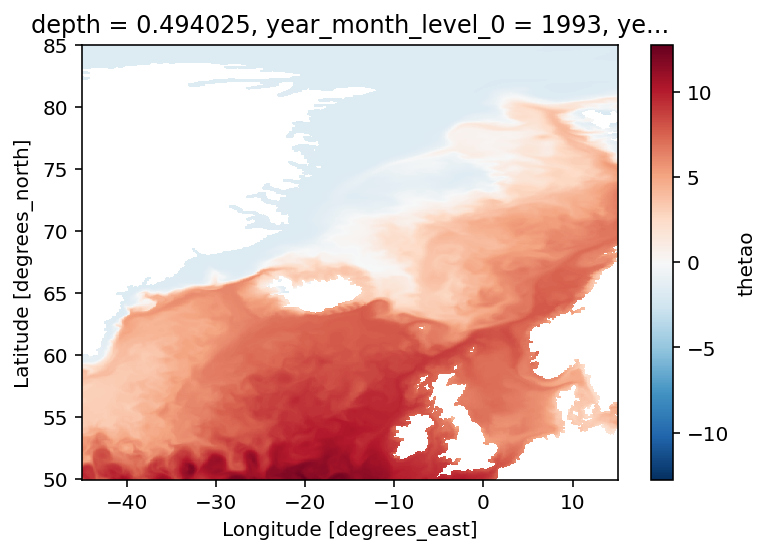

In [18]:
sst_check = xr.open_dataset('glorys_sst_month_mean.nc')
sst_check.thetao.isel(year_month = 0).plot()

In [26]:
# also do bottom temp
%time glorys_full.bottomT.sel(time = slice('2000', '2018')).groupby('year_month').mean('time').reset_index('year_month').to_netcdf('glorys_bt_month_mean.nc') # 13min

u:\documents\conda_dir\myenv1\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Wall time: 10min 7s


min and max bricks for predictor dataframe for survey data. let's just do monthly, what does it really matter. I'm going to group by month, then take the min or max value of each month. 

In [9]:
%time glorys_full.thetao.groupby('year_month').max('time').reset_index('year_month').to_netcdf('glorys_sst_month_max.nc') # 10min

glorys_full.thetao.groupby('year_month').min('time').reset_index('year_month').to_netcdf('glorys_sst_month_min.nc')
glorys_full.bottomT.groupby('year_month').max('time').reset_index('year_month').to_netcdf('glorys_bt_month_max.nc')
glorys_full.bottomT.groupby('year_month').min('time').reset_index('year_month').to_netcdf('glorys_bt_month_min.nc')

u:\documents\conda_dir\myenv1\lib\site-packages\dask\utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
u:\documents\conda_dir\myenv1\lib\site-packages\toolz\functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


Wall time: 10min 14s


In [16]:
tmp= xr.open_dataset('glorys_bt_month_min.nc')
tmp # should be 421 lat bt 721 lon by 312 months (12 * 26 yrs, 1993-2018)

<xarray.Dataset>
Dimensions:             (latitude: 421, longitude: 721, year_month: 312)
Coordinates:
  * latitude            (latitude) float32 50.0 50.083332 ... 84.916664 85.0
  * longitude           (longitude) float32 -45.0 -44.916668 ... 14.916667 15.0
    year_month_level_0  (year_month) int64 ...
    year_month_level_1  (year_month) int64 ...
Dimensions without coordinates: year_month
Data variables:
    bottomT             (year_month, latitude, longitude) float32 ...

In [11]:
tmp.nbytes/1e6 # 378 MB

378.828732

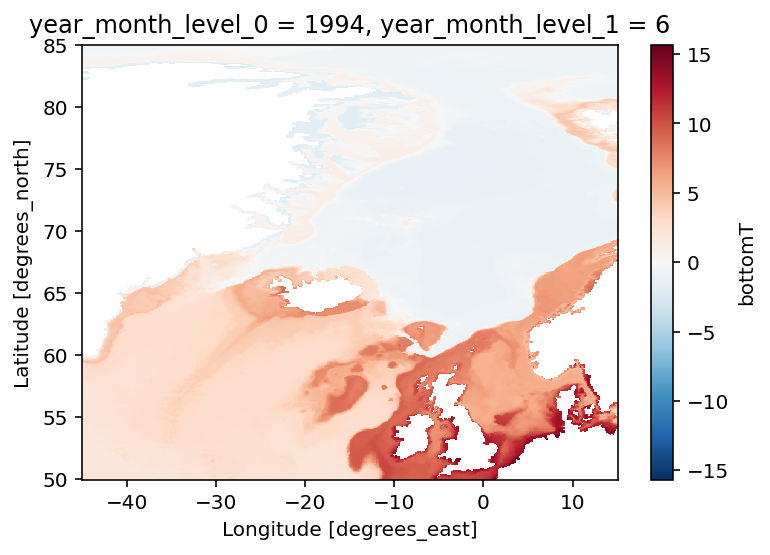

In [18]:
tmp.bottomT.isel(year_month = 17).plot()

### files for calculating stdev

my new genius plan is to just take one layer per month instead of trying to do focal statistics here and take a mean. take the 16th of each month, just like monthly observations. 378mb

In [12]:
# this will also be 312 time steps, but these represent a daily sample, not a mean. 
# https://stackoverflow.com/questions/58526507/xarray-select-only-the-timesteps-which-are-the-first-of-the-month
%time glorys_full.thetao.sel(time = glorys_full.thetao.time.dt.day == 16).to_netcdf('glorys_sst_16_sample.nc')
%time glorys_full.bottomT.sel(time = glorys_full.bottomT.time.dt.day == 16).to_netcdf('glorys_bt_16_sample.nc')

Wall time: 24.5 s
Wall time: 5.69 s


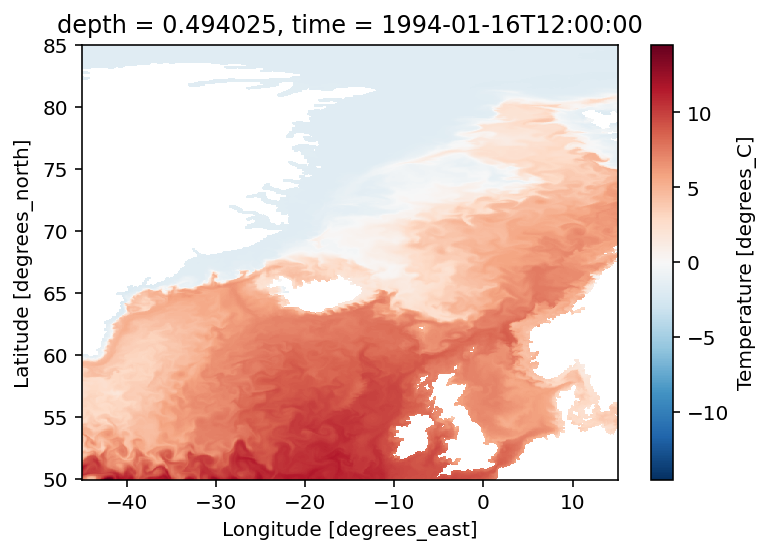

In [16]:
# check
sst_check = xr.open_dataset('glorys_sst_16_sample.nc')
sst_check.thetao.isel(time = 12).plot()

Older code where I was trying to iteratively take crops and delete the daily files. 

In [41]:
months = list(range(2,10))
months_list = [str(item).zfill(2) for item in months]
months_list

['02', '03', '04', '05', '06', '07', '08', '09']

In [24]:
# iteratively open up month files, calculate and save sst and bt, and delete
import os
os.mkdir ('U:/Documents/conda_dir/GLORYS_processed')

In [46]:
path_save_raw = 'U:/Documents/conda_dir/GLORYS/' # omit year for now
path_save_processed = 'U:/Documents/conda_dir/GLORYS_processed/glorys_'

In [42]:
for month in months_list:

    file_path = base_path + 'grepv2_daily_' + '1993' + month + '*.nc'
    month_files = glob.glob(file_path)
    

    month_ds = xr.open_mfdataset (month_files, combine = 'by_coords', chunks = {'depth':15})
    
    # crop to iceland extent
    month_crop = month_ds.thetao_glor.sel (longitude = slice (-45, 15), latitude = slice(50, 85))
    
    # save sst
    sst_file_name = save_path + '1993' + '_' + month + '_sst.nc'
    month_crop.isel(depth = 0).to_netcdf(sst_file_name)
    

    # save bt
    bt_file_name = save_path + '1993' + '_' + month + '_bt.nc'
    bt_crop = xr.apply_ufunc(find_deepest_value, month_crop, input_core_dims = [['depth']], dask = 'allowed', vectorize = True)
    bt_crop.to_netcdf(bt_file_name)
    

    month_ds.close()
    # delete global files
    for file_to_delete in month_files:
        os.remove(file_to_delete)

    
    

In [47]:
# try to double dip, also download files while other script is running
FTP_HOST = "my.cmems-du.eu"
FTP_USER = "jmason1"
FTP_PASS = "JuliaCMEMS2019"

# connect to the FTP server
ftp = FTP(FTP_HOST, FTP_USER, FTP_PASS)
# force UTF-8 encoding
ftp.encoding = "utf-8"

months = list(range(1,13))
months_list = [str(item).zfill(2) for item in months] # add leading zeros

years_list = list(range(2010, 2015))

glorys_path = '/Core/GLOBAL_REANALYSIS_PHY_001_031/global-reanalysis-phy-001-031-grepv2-daily/'

for year in years_list:
    for month in months_list:
        # indicate progress
        print (str(year) + month, sep = '-')
        
        # put together full url string
        month_path = glorys_path + str(year) + '/' + str(month)
        
        # change directory to year and month subfolder
        ftp.cwd (month_path)
        
        # list filenames and download
        filenames = ftp.nlst()
        for filename in filenames:
            local_filename = os.path.join(path_save_raw, filename)
            file = open(local_filename, 'wb')
            ftp.retrbinary('RETR '+ filename, file.write)

            file.close()
            
        # process and delete
        file_path = path_save_raw + 'grepv2_daily_' + str(year) + str(month) + '*.nc'
        month_files = glob.glob(file_path)
    

        month_ds = xr.open_mfdataset (month_files, combine = 'by_coords', chunks = {'depth':15})
    
        # crop to iceland extent
        month_crop = month_ds.thetao_glor.sel (longitude = slice (-45, 15), latitude = slice(50, 85))
    
        # save sst
        sst_file_name = path_save_processed + str(year) + '_' + str(month) + '_sst.nc'
        month_crop.isel(depth = 0).to_netcdf(sst_file_name)
    

        # save bt
        bt_file_name = path_save_processed + str(year) + '_' + str(month) + '_bt.nc'
        bt_crop = xr.apply_ufunc(find_deepest_value, month_crop, input_core_dims = [['depth']], dask = 'allowed', vectorize = True)
        bt_crop.to_netcdf(bt_file_name)
    

        month_ds.close()
        # delete global files
        for file_to_delete in month_files:
            os.remove(file_to_delete)

    
    
    
ftp.quit()
        

201001
201002
201003
201004
201005
201006
201007
201008
201009
201010
201011
201012
201101
201102
201103
201104
201105
201106
201107
201108
201109


KeyboardInterrupt: 

In [36]:
sst_test = xr.open_dataset(save_path + '1993_01_sst.nc')
sst_test.thetao_glor.shape

(31, 141, 241)

In [2]:
# open one month of data
import glob
month_files = glob.glob('U:\Documents\conda_dir\GLORYS\grepv2_daily_199301*.nc')
month_files

['U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930102.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930118.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930114.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930107.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930122.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930112.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930126.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930125.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930104.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930117.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930113.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930121.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930123.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930101.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_19930109.nc',
 'U:\\Documents\\conda_dir\\GLORYS\\grepv2_daily_199301

In [4]:
%time glorys_month_tmp = xr.open_mfdataset (month_files, combine = 'by_coords', chunks = {'depth':15})
glorys_month_tmp.nbytes/1e6 # depth 75, latitutde 681, longitude 1440, time 31. thetao_glor

Wall time: 3.3 s


-127985.871032

In [7]:
%time glorys_crop = glorys_month_tmp.thetao_glor.sel (longitude = slice (-45, 15), latitude = slice(50, 85))
glorys_crop.nbytes/1e6

Wall time: 63 ms


316.0233

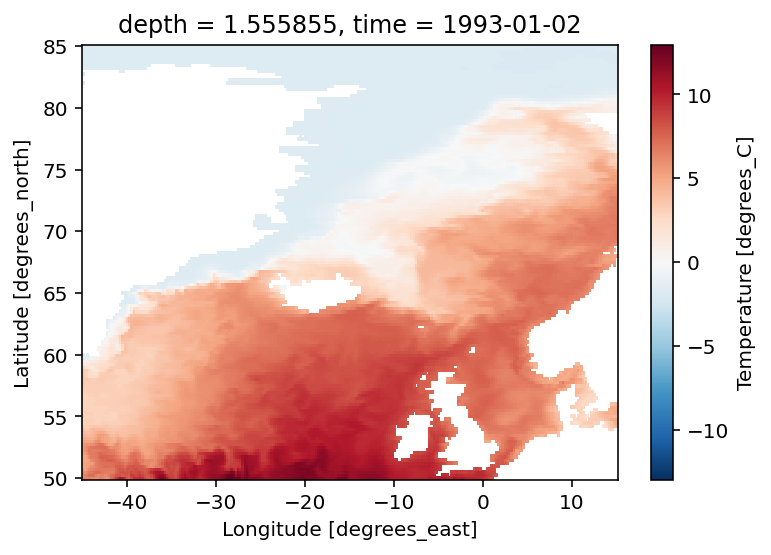

In [8]:
glorys_crop.isel(depth = 1, time = 1).plot()

In [9]:
%time glorys_crop.isel(depth = 0).to_netcdf('glorys_1993_01_sst.nc')

Wall time: 12 s


Wall time: 1min 40s


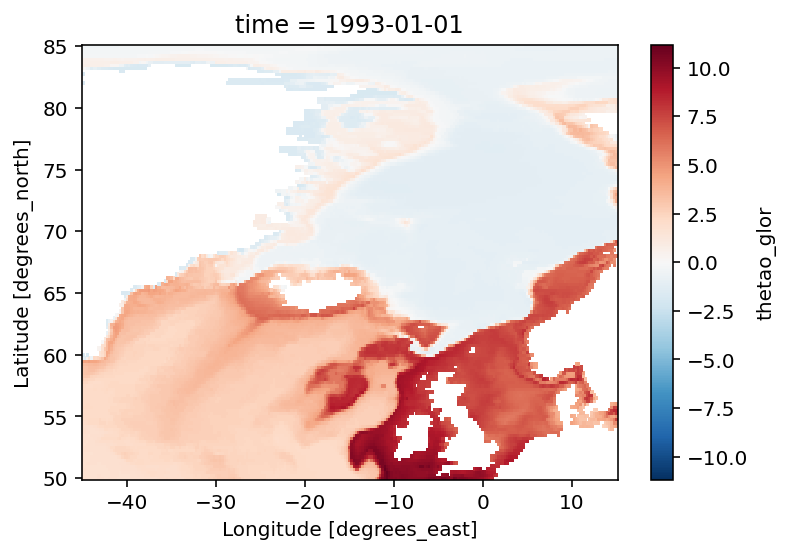

In [12]:
%time glorys_bt_crop = xr.apply_ufunc(find_deepest_value, glorys_crop, input_core_dims = [['depth']], dask = 'allowed', vectorize = True)
glorys_bt_crop.isel(time = 0).plot()

In [14]:
glorys_bt_crop.to_netcdf('glorys_1993_01_bt.nc')

In [35]:
glorys_bt_crop.shape

(31, 141, 241)